# cGAN(Conditional Generative Adversarial Nets) 논문구현

## 특징 : 노이즈 벡터만을 input으로 주는 것이 아닌 label 까지 같이 주어 원하는결과물 확인할 수 있다.



In [1]:
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim  as optim
import time
import os
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

## 데이터 전처리 및 데이터셋 로드

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
]) #transforms 활용하여 전처리

In [4]:
dataset = datasets.MNIST('./data', train = True, transform = trans, download = True) #MNIST데이터셋 활용

In [5]:
img, label = dataset.data, dataset.targets
print(img.shape)
print(label.shape) #60000개의 데이터

torch.Size([60000, 28, 28])
torch.Size([60000])


In [6]:
img = img.unsqueeze(1)
img.shape #차원을 한개 추가해준다

torch.Size([60000, 1, 28, 28])

### 데이터 로더 및 이미지 시각화

In [7]:
trainloader = DataLoader(dataset, batch_size = 64, shuffle = True)
data, img = iter(trainloader).next()
data.size()

torch.Size([64, 1, 28, 28])

In [7]:
def img_show(img):
    plt.figure(figsize = (10, 10))
    plt.imshow(torchvision.utils.make_grid(img, normalize = True).permute(1,2,0)) # H, W, C로 변경
    plt.show()

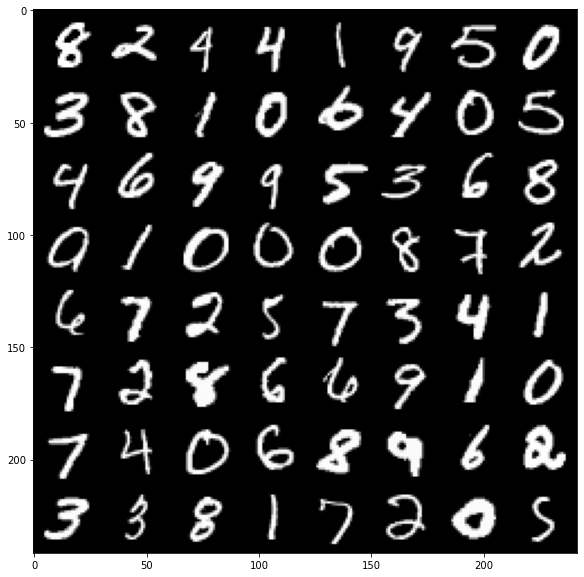

In [8]:
for data, label in trainloader:
    img_show(data)
    break

## 생성자 정의

### nn.Embedding을 사용하여 라벨이라는 새로운 정보를 Generator에게 준다

In [8]:
class Generator(nn.Module):
    def __init__(self, num_classes, num_noise, input_size):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.num_noise = num_noise
        self.input_size = input_size
        
        self.label_emb = nn.Embedding(num_embeddings = self.num_classes, embedding_dim = self.num_classes)
        #Embedding 을 통해 각 label은 고유벡터를 가지게된다. 
        self.gen = nn.Sequential(
        nn.Linear(self.num_noise + self.num_classes, 128),nn.LeakyReLU(0.2), #128개의 입력을 받게된다.
        nn.Linear(128, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2),
        nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2),
        nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.LeakyReLU(0.2),
        nn.Linear(1024, np.prod(self.input_size)),#10개의 고유벡터와 100개의노이즈 벡터로부터 이미지 생성
            nn.Tanh()#여기서 고유벡터를 통해 학습에 대해 이정표를 준다고 할 수 있다.
        )
        
    def forward(self, noise, labels):
        gan_input = torch.cat((self.label_emb(labels), noise), -1) #입력 받은노이즈와 라벨(고유벡터)을 같이 합쳐준다.
        x = self.gen(gan_input)
        x = x.view(x.size(0), *self.input_size) #입력을 튜플로 받으므로 *필요
        return x

### 차원 맞는지 확인해보기

In [9]:
check_x = torch.randn(16, 100) # 노이즈
label = torch.randint(0, 10, (16,))
model_gen = Generator(10, 100, (1, 28, 28))
out_gen = model_gen(check_x, label)
print(out_gen.shape) #이미지가 B * C * H * W 로 잘 나온 것을 확인

torch.Size([16, 1, 28, 28])


## 구별자 정의

In [10]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, input_size):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        
        self.label_embedding = nn.Embedding(num_embeddings = self.num_classes, embedding_dim = self.num_classes)
        
        self.dis = nn.Sequential(
        nn.Linear(self.num_classes + np.prod(self.input_size), 512), nn.LeakyReLU(0.2), 
        nn.Linear(512, 512), nn.Dropout(0.4), nn.LeakyReLU(0.2), #마찬가지로 고유벡터와 이미지를 input으로 받는다.
        nn.Linear(512, 512), nn.Dropout(0.4), nn.LeakyReLU(0.2),
        nn.Linear(512, 1), nn.Sigmoid())
        #0~1의 결과값을 output으로 뱉는다.
    def forward(self, img, labels):
        dis_input = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
    
        x = self.dis(dis_input)
        return x

### 차원 맞는지 확인해보기

In [12]:
check_x = torch.rand(16, 1, 28, 28)
label = torch.randint(0, 10, (16,))
model_dis = Discriminator(10, (1, 28, 28))
out_dis = model_dis(check_x, label)
print(out_dis.shape) #배치사이즈와 각 0~1의 값을 가지는 벡터를 output으로 내보낸다.

torch.Size([16, 1])


In [13]:
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        print('FC layer 가중치 초기화')
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        print('Batch layer 가중치 초기화')

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

FC layer 가중치 초기화
FC layer 가중치 초기화
Batch layer 가중치 초기화
FC layer 가중치 초기화
Batch layer 가중치 초기화
FC layer 가중치 초기화
Batch layer 가중치 초기화
FC layer 가중치 초기화
FC layer 가중치 초기화
FC layer 가중치 초기화
FC layer 가중치 초기화
FC layer 가중치 초기화


## 학습

In [14]:
loss_func = nn.BCELoss() 

optim_gen = optim.Adam(model_gen.parameters(), lr = 2e-4, betas = (0.5, 0.999))
optim_dis = optim.Adam(model_dis.parameters(), lr = 2e-4, betas = (0.5, 0.999))

In [15]:
num_epochs = 100
loss_history = {'gen' : [], 'dis' : []}

In [17]:
torch.randint(0,10,(5,))

tensor([7, 7, 6, 8, 5])

In [18]:
batch_count = 0
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for img, label in trainloader:
        num_batch = img.shape[0]
        label_real = torch.Tensor(num_batch, 1).fill_(1.0) 
        label_fake = torch.Tensor(num_batch, 1).fill_(0.0)
        
        #Generator
        
        model_gen.zero_grad()
        noise = torch.rand(num_batch, 100) #노이즈 생성
        gen_label = torch.randint(0,10, (num_batch,)) # 0~9까지의 batch만큼의 라벨 생성
        
        # fake 이미지 생성
        out_gen = model_gen(noise, gen_label)
        # fake 이미지 판별
        out_dis = model_dis(out_gen, gen_label)
        
        loss_gen = loss_func(out_dis, label_real)
        loss_gen.backward()
        optim_gen.step()
        
        #Discriminator
        
        model_dis.zero_grad()
        
        #real 이미지 판별
        out_dis = model_dis(img, label)
        loss_real = loss_func(out_dis, label_real)
        
        #fake 이미지 판별
        out_dis = model_dis(out_gen.detach(), gen_label) #discriminator를 훈련하므로 generator는 훈련 x
        loss_fake = loss_func(out_dis, label_fake)
        
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        optim_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print(f'Epoch : {epoch} G_loss : {loss_gen.item():.3f}, D_loss : {loss_dis.item():.3f}' )

Epoch : 1 G_loss : 1.595, D_loss : 0.746
Epoch : 2 G_loss : 1.433, D_loss : 0.656
Epoch : 3 G_loss : 0.974, D_loss : 0.534
Epoch : 4 G_loss : 1.109, D_loss : 0.455
Epoch : 5 G_loss : 1.079, D_loss : 0.562
Epoch : 6 G_loss : 1.482, D_loss : 0.482
Epoch : 7 G_loss : 1.527, D_loss : 0.384
Epoch : 8 G_loss : 1.756, D_loss : 0.537
Epoch : 9 G_loss : 1.291, D_loss : 0.409
Epoch : 10 G_loss : 0.920, D_loss : 0.442
Epoch : 11 G_loss : 2.733, D_loss : 0.629
Epoch : 12 G_loss : 1.035, D_loss : 0.519
Epoch : 13 G_loss : 1.887, D_loss : 0.512
Epoch : 14 G_loss : 2.053, D_loss : 0.295
Epoch : 15 G_loss : 1.336, D_loss : 0.371
Epoch : 17 G_loss : 1.726, D_loss : 0.342
Epoch : 18 G_loss : 1.573, D_loss : 0.352
Epoch : 19 G_loss : 1.578, D_loss : 0.269
Epoch : 20 G_loss : 1.938, D_loss : 0.402
Epoch : 21 G_loss : 2.195, D_loss : 0.297
Epoch : 22 G_loss : 2.061, D_loss : 0.223
Epoch : 23 G_loss : 2.372, D_loss : 0.323
Epoch : 24 G_loss : 2.104, D_loss : 0.390
Epoch : 25 G_loss : 1.566, D_loss : 0.309
E

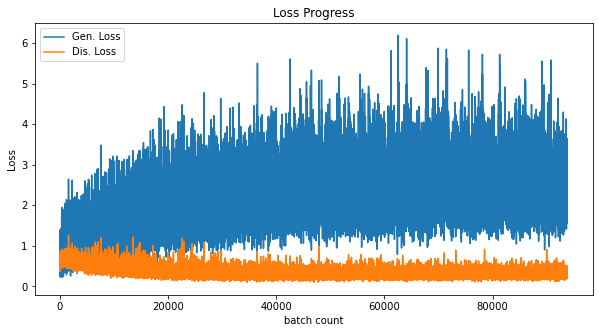

In [19]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pth')
path2weights_dis = os.path.join(path2models, 'weights_dis.pth')

In [21]:
torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [22]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100)
    label = torch.randint(0,10,(16,))
    img_fake = model_gen(fixed_noise, label).detach().cpu()
print(img_fake.shape)


torch.Size([16, 1, 28, 28])


## 결과물 시각화

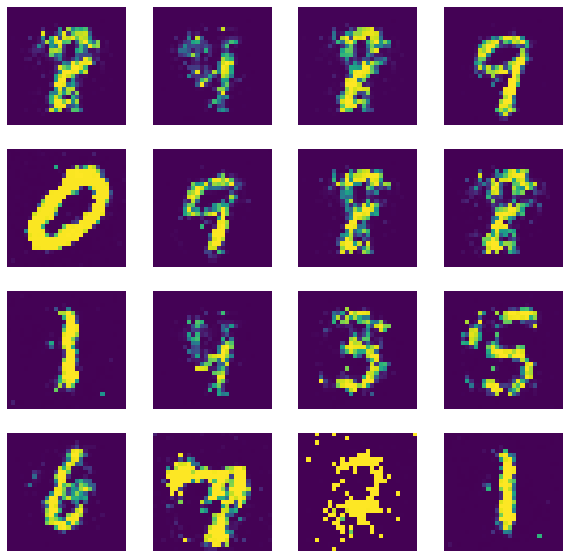

In [23]:
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(img_fake[ii]))
    plt.axis('off')

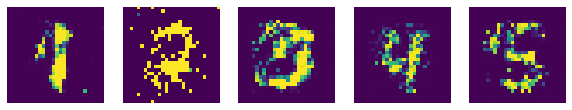

In [55]:
data = [1,2,3,4,5]
fixed_noise = torch.randn(5, 100)
label = torch.LongTensor(data)
img_fake = model_gen(fixed_noise, label).detach().cpu()


plt.figure(figsize=(10,10))
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(to_pil_image(img_fake[ii]))
    plt.axis('off')